In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '..', 'vision_fit'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
# plt.style.use('dark_background')
from mog_fit import data
from collections import OrderedDict
from sklearn import preprocessing
import torch
from torch.autograd import Variable
from mog_analyze import viz
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

from vision_fit import data
import viz_weights
from process_results import process_results

%matplotlib inline
%load_ext autoreload
%autoreload 2

import style
cb = '#008fd5'
cr = '#fc4f30'

In [2]:
style.set_style()

# load results from a directory

In [3]:
pid_a = '07665771801545027002'
pid_s = '24656068102223723425'

# depending on how much is saved, this may take a while
out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/resweep_full_new'
out_dir2 = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/resweep_full_new2'
fnames = sorted([oj(out_dir, fname) for fname in os.listdir(out_dir) \
                 if not fname.startswith('weights') \
                 and not fname.startswith('idx')
                 and (pid_a in fname or pid_s in fname)]) + \
         sorted([oj(out_dir2, fname) for fname in os.listdir(out_dir2) \
                 if not fname.startswith('weights') \
                 and not fname.startswith('idx')
                 and (pid_a in fname or pid_s in fname)])    
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in tqdm(fnames) 
                if not fname.startswith('weights') and not fname.startswith('idx') and (pid_a in fname or pid_s in fname)]
results = pd.concat(results_list, axis=1).T.infer_objects()
print(results.shape)

100%|██████████| 2/2 [00:00<00:00,  8.21it/s]

(2, 54)


**add cols**

In [4]:
# adds these vec keys: fc0_fro, fc1_fro, fc0_stab_rank, fc1_stab_rank, act0_stab_rank, act1_stab_rank, corr0, corr1
# adds these scalar keys: max_train_acc, max_test_acc, _final of all the above
# print('before', results.shape)
its, ts, results = process_results(results)
print('after', results.shape)

after (2, 84)


# pick examples

In [5]:
pre_a = '24421'
pre_s = '40043'

r = results
for pid in r.pid:
    if pid.startswith(pre_a):
        print('a', pid)
    if pid.startswith(pre_s):
        print('s', pid)

# good for 128
# pid_a = '24421020350011741116'
# pid_s = '40043048138378577087'

# good for 512
pid_a = '07665771801545027002'
pid_s = '24656068102223723425'

In [6]:
# depending on how much is saved, this may take a while
out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/resweep_full_new'
out_dir2 = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/resweep_full_new2'
fnames = sorted([oj(out_dir, fname) for fname in os.listdir(out_dir) \
                 if (pid_a in fname or pid_s in fname)]) + \
         sorted([oj(out_dir2, fname) for fname in os.listdir(out_dir2) \
                 if (pid_a in fname or pid_s in fname)])

# weights
fnames_w = [fname for fname in fnames if 'weights' in fname]
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in fnames_w]
rw = pd.concat(results_list, axis=1).T.infer_objects()

# normal results
fnames_acc = [fname for fname in fnames if '/pid' in fname] # normal results
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in fnames_acc]
r = pd.concat(results_list, axis=1).T.infer_objects()
its, ts, r = process_results(r)

# get individual weights
rw_sgd = rw[rw.optimizer == 'sgd'].reset_index().iloc[0]
rw_adam = rw[rw.optimizer == 'adam'].reset_index().iloc[0]

# get accs
r_sgd = r[r.optimizer == 'sgd'].reset_index().iloc[0]
r_adam = r[r.optimizer == 'adam'].reset_index().iloc[0]

In [16]:
epoch = int(max(ts))
print('epoch', epoch, r_sgd.max_test_acc, r_adam.max_test_acc, r_sgd.max_train_acc, r_adam.max_train_acc)
print('sgd', r_sgd.accs_train[its == epoch], r_sgd.accs_test[its == epoch])
print('adam', r_adam.accs_train[its == epoch], r_adam.accs_test[its == epoch])

epoch 111 0.9706 0.9704 0.9999333333333333 0.9996833333333334
sgd [0.9999] [0.9692]
adam [0.99951667] [0.9679]


# prune by magnitude, see if acc goes down

In [63]:
# all info in [r_sgd, r_adam], [rw_sgd, rw_adam]
def calc_accs(model, X_train, Y_train, X_test, Y_test):
    preds = model(X_train).data.cpu().numpy().argmax(axis=1)
    accs_train = preds==Y_train
    preds = model(X_test).data.cpu().numpy().argmax(axis=1)
    accs_test = preds==Y_test
    return np.mean(accs_train), np.mean(accs_test)


# takes in weights_dict copy
# zeros the k weights with the smallest norms
# returns new weights dict
def zero_top_k(weights_dict, k=1, lay='fc.0.weight'):
    w_orig = deepcopy(weights_dict[lay])
    if k > 0:
        norms = np.linalg.norm(w_orig, axis=1)
        idxs_smallest = np.argsort(norms)[:k]
        w_orig[idxs_smallest] = 0 * w_orig[idxs_smallest]
    weights_dict_copy = deepcopy(weights_dict)
    weights_dict_copy[lay] = w_orig
    return weights_dict_copy

accs_train = {'sgd': [], 'adam': []}
accs_test = {'sgd': [], 'adam': []}
for run in [rw_sgd, rw_adam]:
    print(run.optimizer)
        
    # get data
    run['num_layer'] = int(run['num_layers'])
    run['hidden_size'] = int(run['hidden_size'])
    run['batch_size'] = int(run.batch_size)
    train_loader, test_loader = data.get_data_loaders(run)
    X_train, Y_train, X_test, Y_test = data.process_loaders(train_loader, test_loader)
    
    # load in weights
    model = data.get_model(run)
    weights_dict_dict = run['weights'] # keys are epochs, vals are dicts of all weights
    weights_dict = weights_dict_dict[epoch] # keys are layers, vals are weight values    

    # prune 1st lay weights by magnitude and see how acc changes    
    for k in tqdm(range(512)):
        weights_dict_copy = zero_top_k(weights_dict, k=k)
        weights_dict_tensors = {k: torch.Tensor(v) for k, v in weights_dict_copy.items()}
        model.load_state_dict(weights_dict_tensors)
        model = model.cuda()
        acc_train, acc_test = calc_accs(model, X_train, Y_train, X_test, Y_test)
        accs_train[run.optimizer].append(acc_train)
        accs_test[run.optimizer].append(acc_test)         

sgd


100%|██████████| 512/512 [01:16<00:00,  6.93it/s]


adam


100%|██████████| 512/512 [00:18<00:00, 27.99it/s]


In [84]:
weights_dict.keys()

dict_keys(['fc.1.bias', 'fc.1.weight', 'fc.0.weight', 'fc.0.bias'])

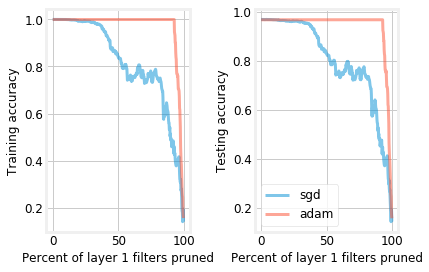

In [75]:
plt.subplot(121)
plt.ylabel('Training accuracy')
plt.plot(np.arange(512) / 512 * 100, accs_train['sgd'], label='sgd')
plt.plot(np.arange(512) / 512 * 100, accs_train['adam'], label='adam')
plt.xlabel('Percent of layer 1 filters pruned')
# plt.legend()

plt.subplot(122)
plt.ylabel('Testing accuracy')
plt.plot(np.arange(512) / 512 * 100, accs_test['sgd'], label='sgd')
plt.plot(np.arange(512) / 512 * 100, accs_test['adam'], label='adam')
plt.xlabel('Percent of layer 1 filters pruned')
plt.legend()



plt.tight_layout()
plt.savefig('pruning.pdf')
plt.show()

# unrelated: check if bigger norm -> bigger mem

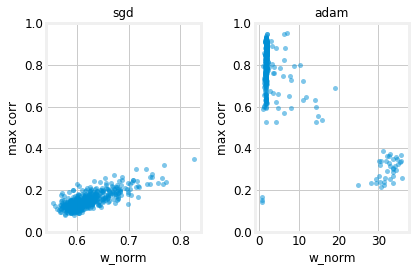

In [81]:
r = results
tmax = max(ts)

plt.subplot(121)
r_sgd = r[r.optimizer == 'sgd'].iloc[0]
d = r_sgd['mean_max_corrs'][tmax]['fc.0.weight']
plt.plot(d['W_norms'], d['max_corrs'], '.')
plt.xlabel('w_norm')
plt.ylabel('max corr')
plt.ylim(0, 1)
plt.title('sgd')

plt.subplot(122)
r_adam = r[r.optimizer == 'adam'].iloc[0]
d = r_adam['mean_max_corrs'][tmax]['fc.0.weight']
plt.plot(d['W_norms'], d['max_corrs'], '.')
plt.xlabel('w_norm')
plt.ylabel('max corr')
plt.title('adam')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('corr_vs_norm.pdf')
plt.show()